In [1]:
# Note: NA19434 looks suspicious... lots of errors for that sample

In [2]:
%pylab inline
import pandas as pd
import json
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name(
    '/storage/mgymrek/workspace/capillary-electrophoresis-webserver/capillaryelectrophoresis-e683d5dd37a2.json', scope)
gc = gspread.authorize(credentials)

def LoadGSheet(wks):
    data = wks.get_all_values()
    headers = data.pop(0)
    return pd.DataFrame(data, columns=headers)

Populating the interactive namespace from numpy and matplotlib


In [3]:
colordict = {
    "PlatinumGenomes": "red",
    "GIAB": "blue",
    "1000Genomes": "green"
}
sampdata = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("samples"))
sampdata["color"] = sampdata["SampleCollection"].apply(lambda x: colordict[x])
sampcolors = dict(zip(list(sampdata["SampleID"]), list(sampdata["color"])))

In [4]:
############### Load list of loci to consider ###########
loci = pd.read_csv('../data/csv/1000g_loci.csv')
primer_ids = set(loci["LocusID"])

In [5]:
############### Load product sizes from google sheet ###########
psdata = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("product size"))
psdata = psdata[psdata["PrimerID"].isin(primer_ids)][["PrimerID","SampleID","Product size"]]
psdata.columns = ["PrimerID", "SampleID","ProductSize"]
psdata["SampleID"] = psdata["SampleID"].apply(lambda x: x.strip())

# Sample product sizes
samp_prod_sizes = psdata[~psdata["SampleID"].isin(["Reference", "reference"])]
samp_prod_sizes = samp_prod_sizes[samp_prod_sizes["ProductSize"].apply(lambda x: "/" in x and x.split("/")[1].strip() != "")]
samp_prod_sizes[["prd_size_1", "prd_size_2"]] = samp_prod_sizes["ProductSize"].str.split('/', expand=True)[[0,1]].astype(float).astype(int) #round(0)

In [6]:
############### Load ref product sizes ###########
ref_prod_sizes = LoadGSheet(gc.open("1000GenomesRepeatValidationDatabase").worksheet("RefProductSizes"))

rmloci = ["AR","NOS1","FMR1","CNBP","chr12_131901040_T","chr12_75962280_T","chr12_92269453_T", \
    "chr15_72443969_T","chr16_58599051_A","chr16_67644335_T","chr3_54501407_T", \
    "chr4_176019003_T", "AFF2","ARX","chr7_103989357_CCG","RUNX2","C9orf72","chr12_4096182_TTCC","PHOX2B","HOXD13","PAPBN1"]
ref_prod_sizes = ref_prod_sizes[~ref_prod_sizes["PrimerID"].isin(rmloci)]

In [7]:
############### Load product sizes from VCFs ###########
# load json for gangstr
with open('../data/json/gangstr_calls.json', 'r') as f:
    gangstr_calls = json.load(f)
# load json for hipstr
with open('../data/json/hipstr_calls.json', 'r') as f:
    hipstr_calls = json.load(f)

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


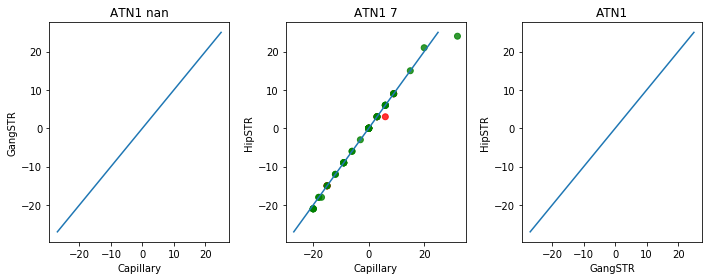

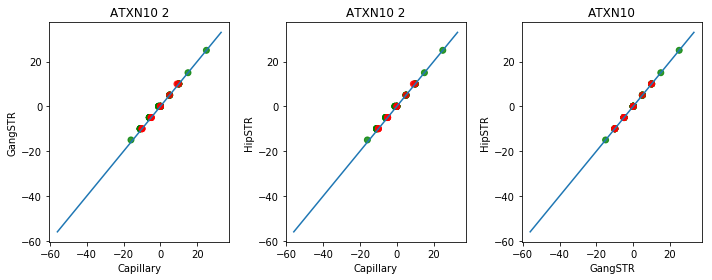

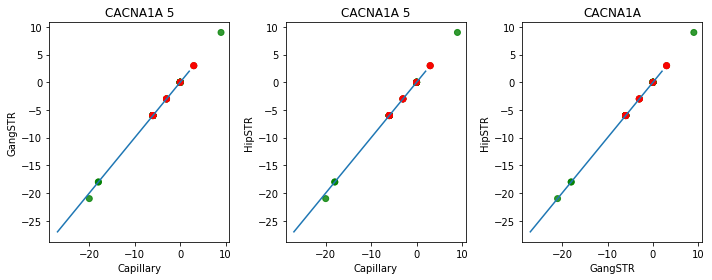

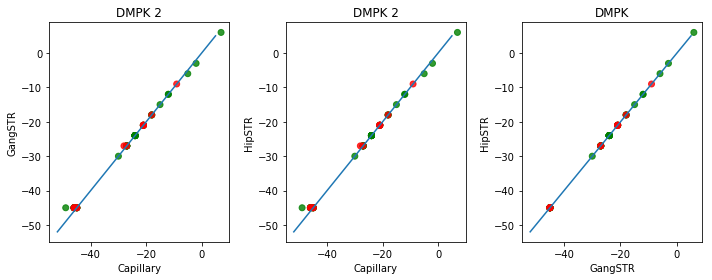

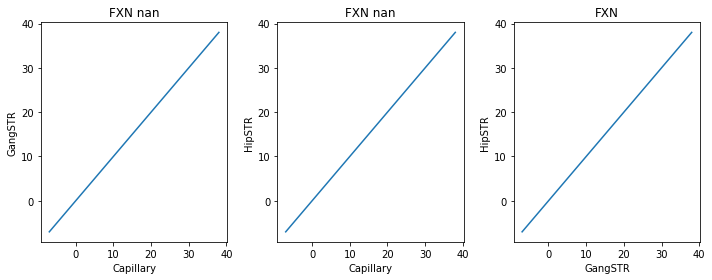

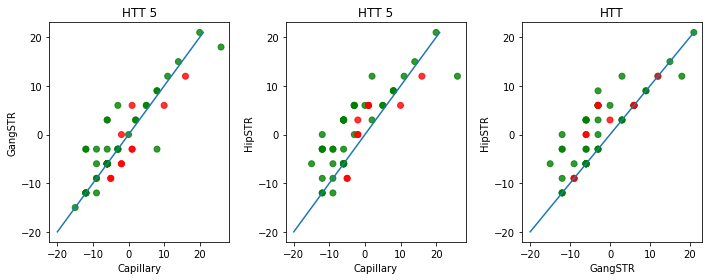

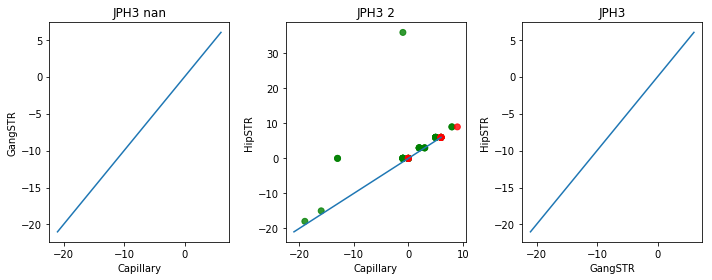

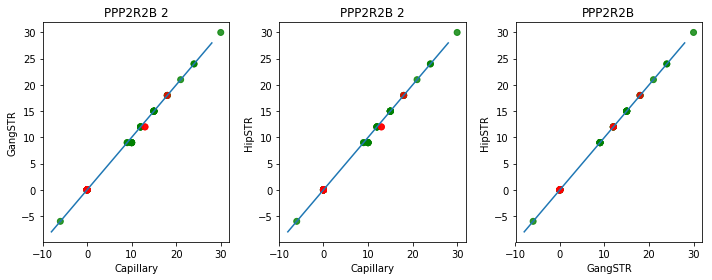

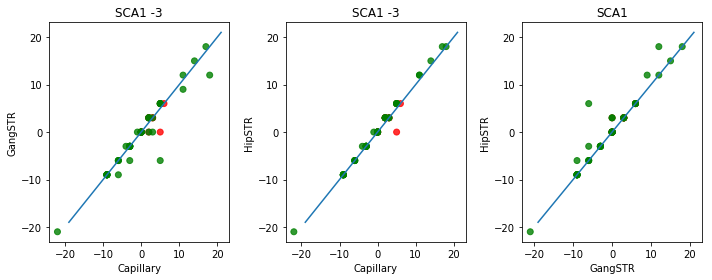

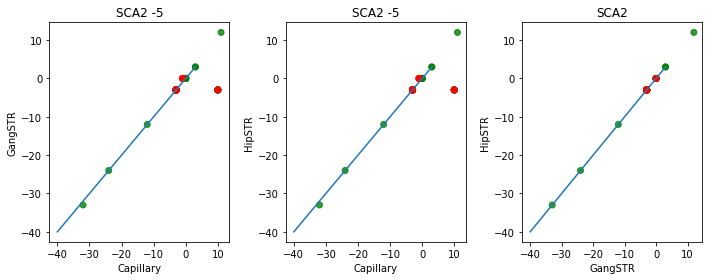

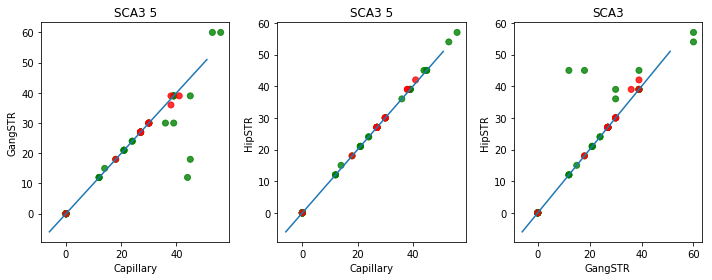

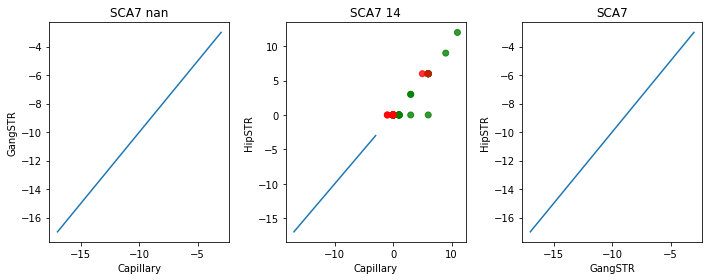

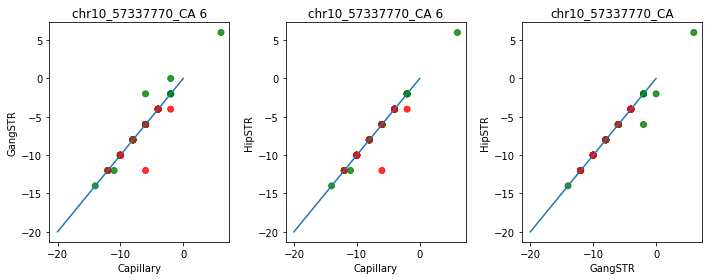

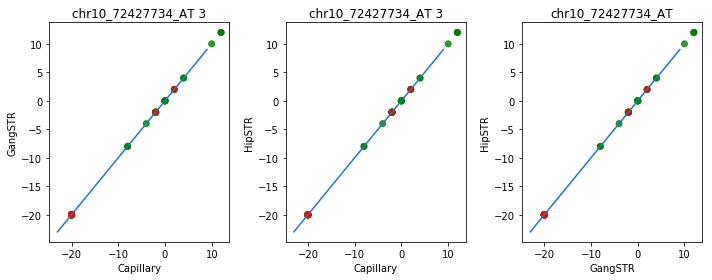

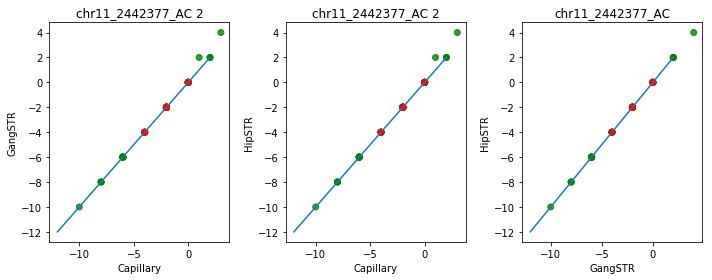

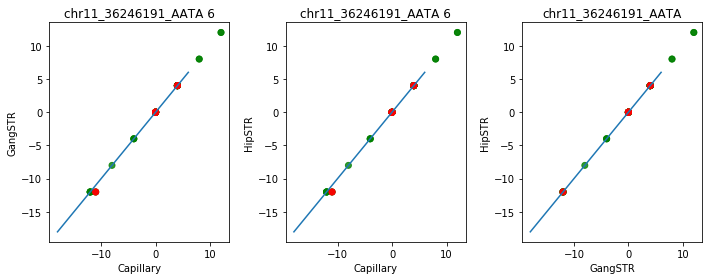

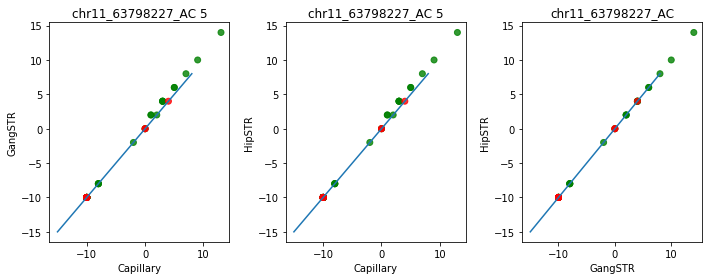

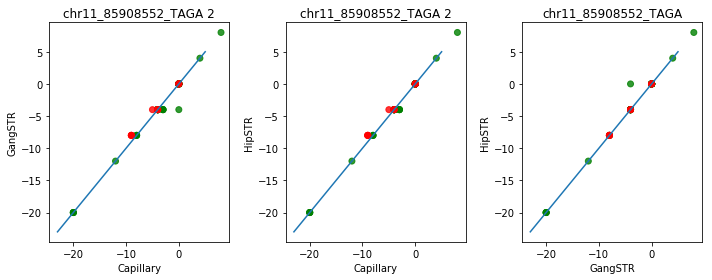

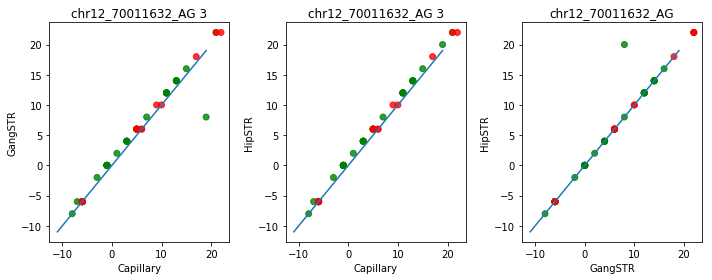

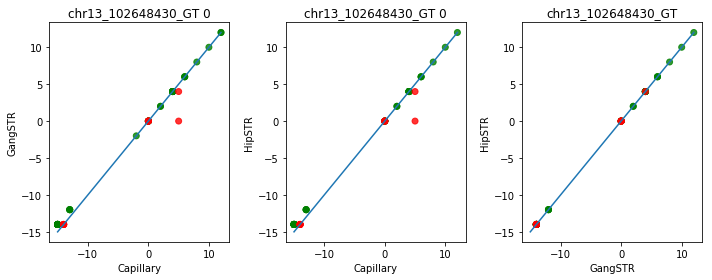

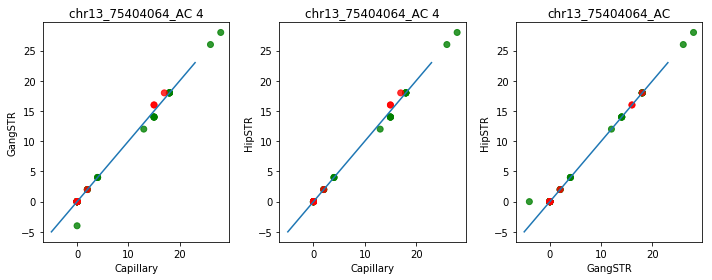

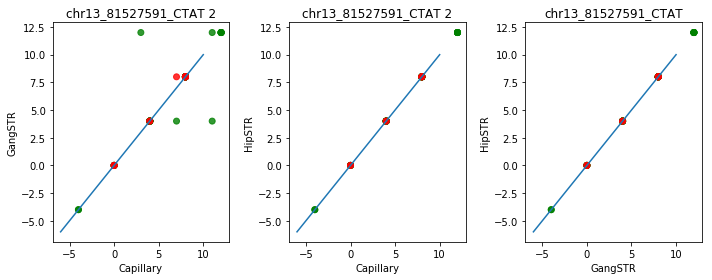

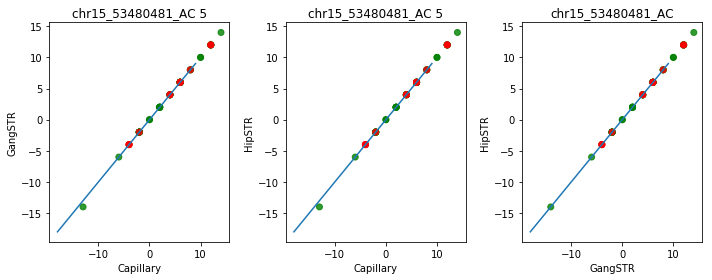

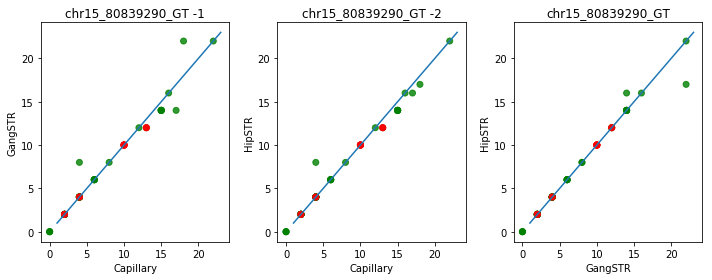

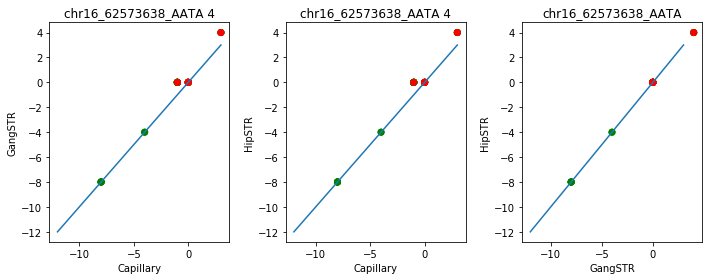

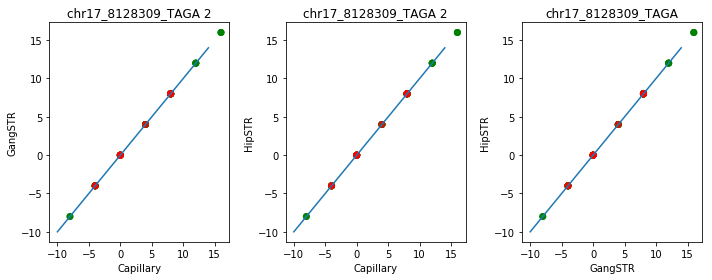

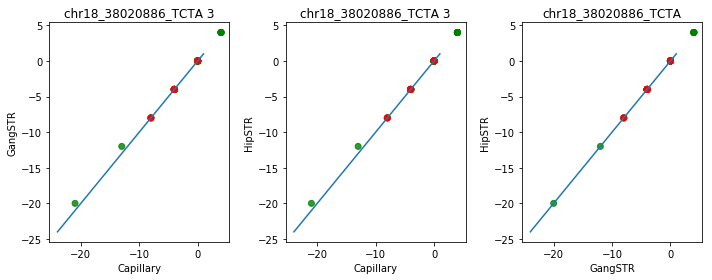

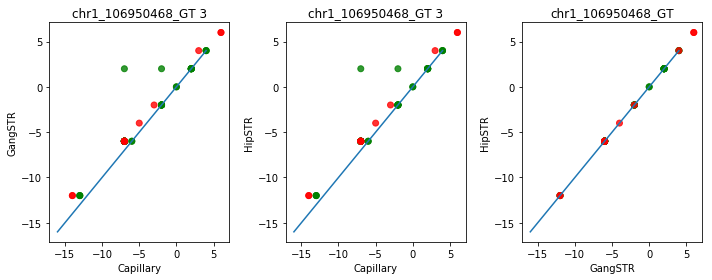

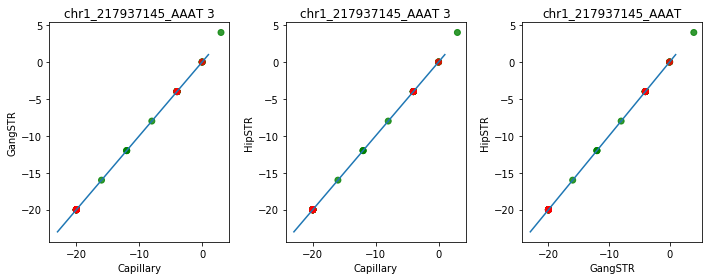

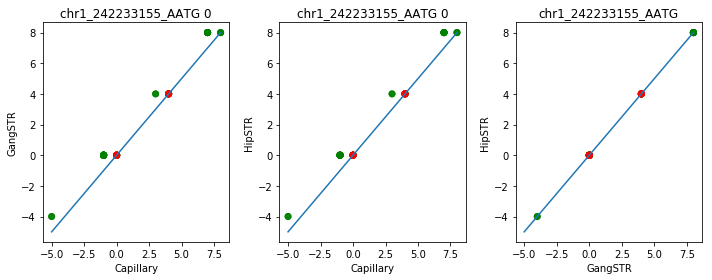

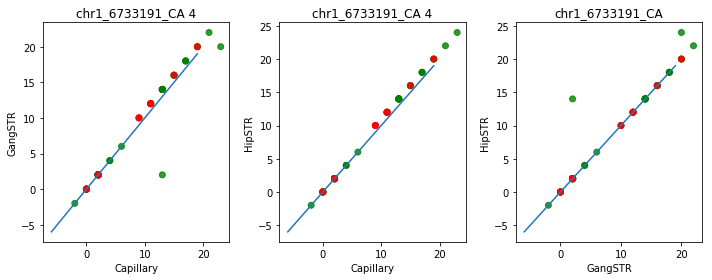

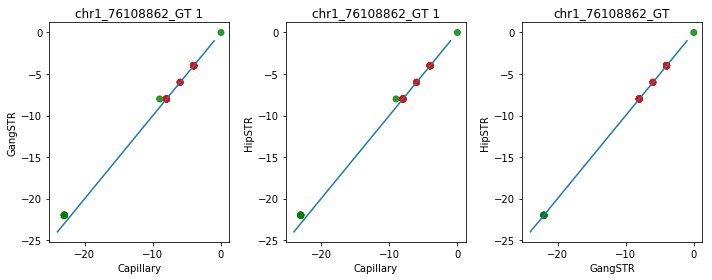

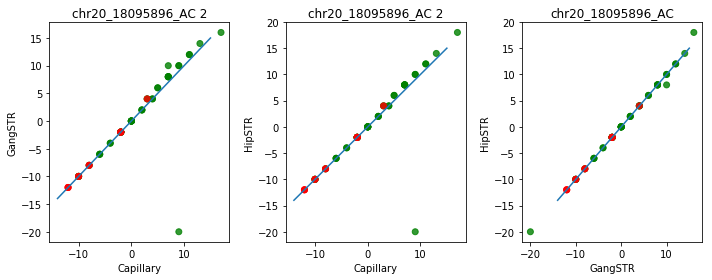

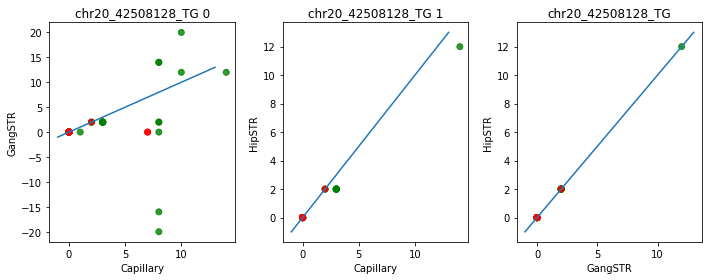

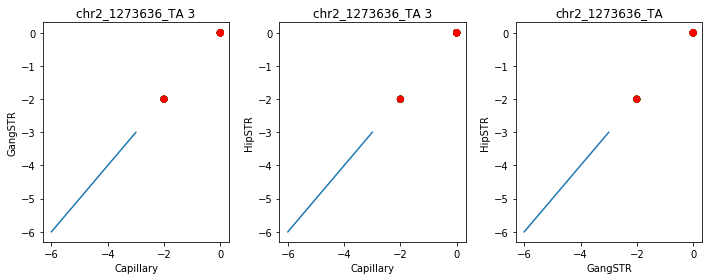

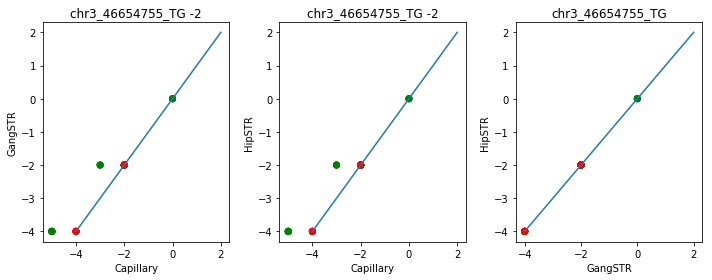

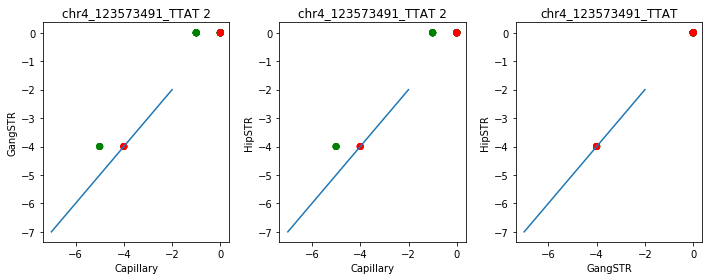

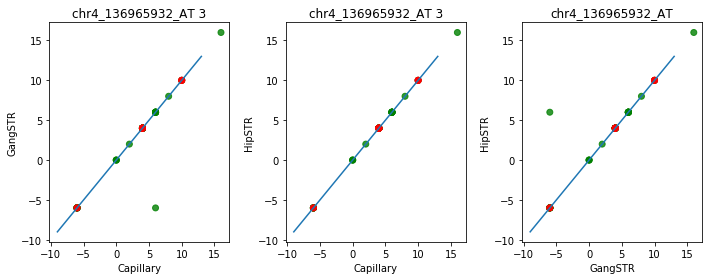

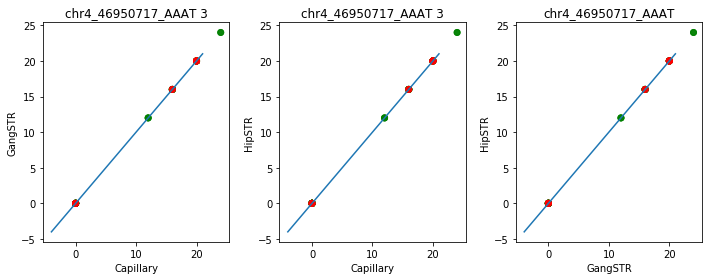

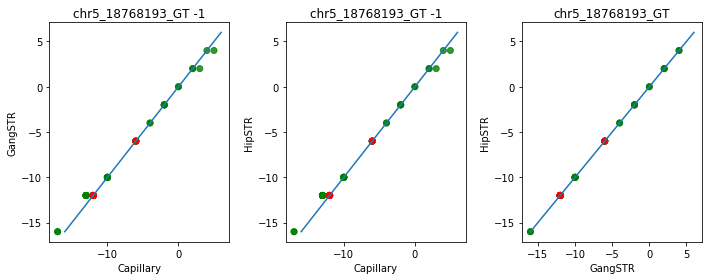

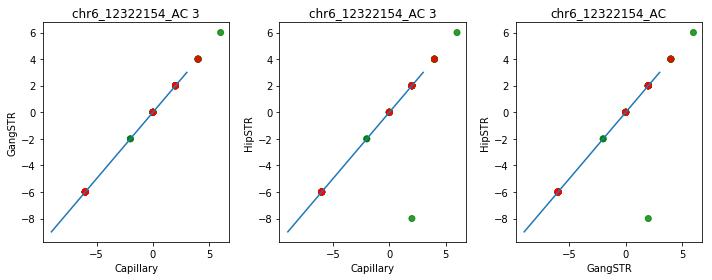

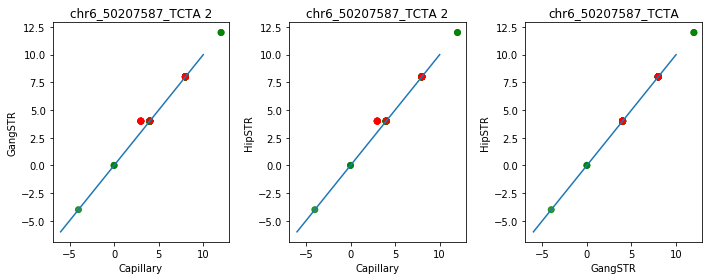

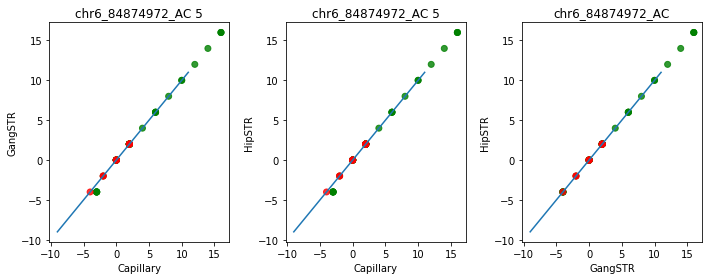

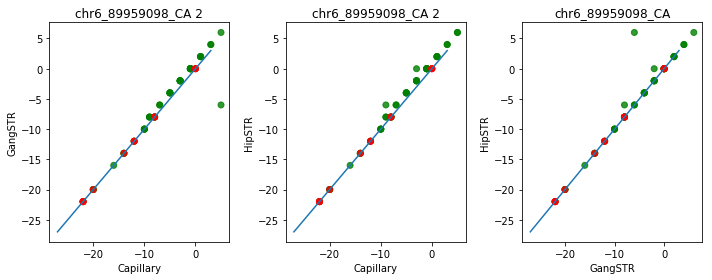

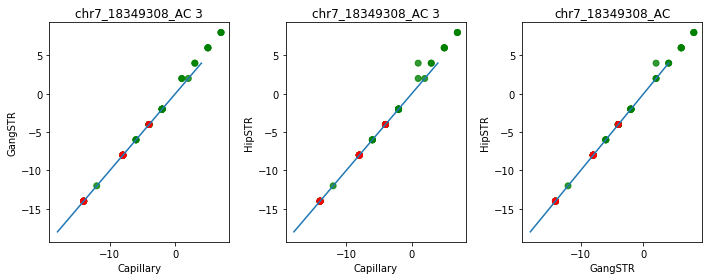

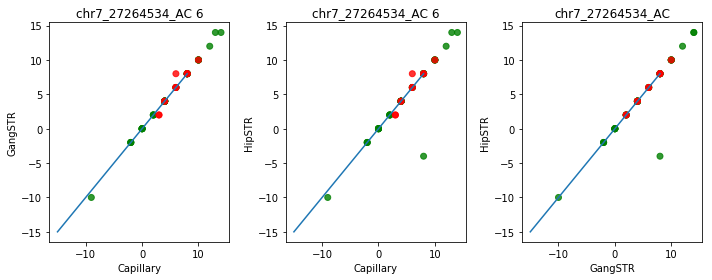

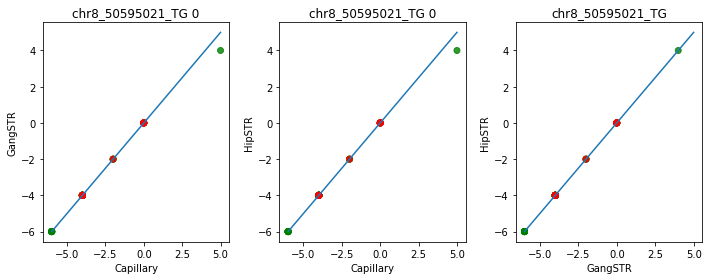

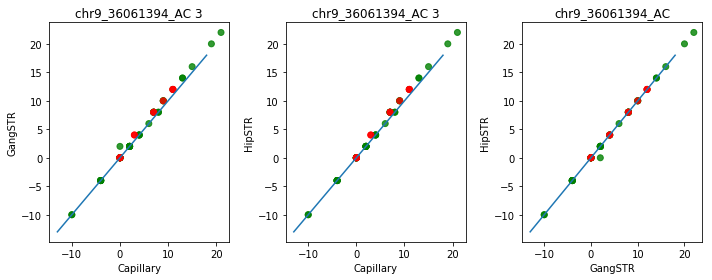

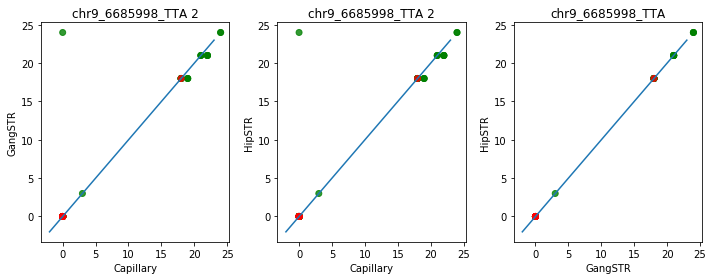

In [8]:
# Y = X + offset
def find_offset (X, Y, period):
    newX = [X[i] for i in range(len(X)) if not np.isnan(Y[i])]
    newY = [item for item in Y if not np.isnan(item)]
    
    if len(newX) == 0: return np.nan, np.nan, np.nan
    # measure: diffs in sizes
    most_matches = -10
    best_diffs = 100000
    best_offset = -1000
    for offset in range(-30,30):
        x_plus_off = [x + offset for x in newX]
        
        # Get matches after round to nearest repeat unit
        rounded_x = [round(item/period) for item in x_plus_off]
        rounded_y = [round(item/period) for item in newY]
        num_matches = sum(np.equal(rounded_x, rounded_y))
        
        # Get diffs. Take top %percentile since we don't know how many calls are wrong
        diffs = [abs(x_plus_off[i]-newY[i]) for i in range(len(x_plus_off))]
        diff = np.max(sorted(diffs)[0:10]) #np.median(diffs)
        
        if diff < best_diffs:
            best_diffs = diff
            best_offset = offset
            most_matches = num_matches
    return best_offset, most_matches, best_diffs

# Overall offset. also try to learn separately
offsets = []
offsets_PG = []
offsets_Coriell = []

# Data for call-level comparison
loci_ = []
samples_ = []
cap_ = []
capraw_ = []
hip_ = []
gang_ = []
offs_ = []

for PrimerID in sorted(set(ref_prod_sizes["PrimerID"])):
    period = len(loci[loci["LocusID"]==PrimerID]["Motif"].values[0])
    ref_prod_size = ref_prod_sizes[ref_prod_sizes["PrimerID"]==PrimerID]["ProductSize"].values[0]    
    samp_loc_prod_sizes = samp_prod_sizes[samp_prod_sizes["PrimerID"]==PrimerID]
    
    X = [] # product size from capillary - ref
    X_raw = [] # Product size unadjusted
    Y_gstr = [] # product size from gangstr
    Y_hstr = [] # product size from hipstr
    samples = [] # sample list

    allsamples = list(samp_loc_prod_sizes["SampleID"])

    for sample in allsamples:
        # Extract capillary data
        cap_prod_sizes = list(samp_loc_prod_sizes.set_index('SampleID').loc[sample][['prd_size_1', 'prd_size_2']])
        
        if "prd_size_1" in cap_prod_sizes: continue
        gb_cap = sorted([float(i) - float(ref_prod_size) for i in cap_prod_sizes])
        if sum(np.isnan(gb_cap)) > 0: continue 
        X.extend(gb_cap)
        X_raw.extend(sorted([float(i) for i in cap_prod_sizes]))
        samples.extend([sample]*2)

        # Extract gangstr and hipstr data
        try:
            gb_gstr = sorted([float(i) for i in gangstr_calls[PrimerID][sample]['gb'].split(',')])
        except: gb_gstr = [np.nan, np.nan]
        Y_gstr.extend(gb_gstr)
            
        try:
            gb_hstr = sorted([float(i) for i in hipstr_calls[PrimerID][sample]['gb'].split(',')])
        except:
            gb_hstr = [np.nan, np.nan]
        Y_hstr.extend(gb_hstr)  
        
    if len(X) == 0:
        offsets.append(np.nan)
        continue

    offset_gstr, num_matches_gstr, diff_gstr = find_offset(X, Y_gstr, period)
    offset_hstr, num_matches_hstr, diff_hstr = find_offset(X, Y_hstr, period)

    X_PG = [X[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="red"]
    Y_gstr_PG = [Y_gstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="red"]
    Y_hstr_PG = [Y_hstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="red"]
    offset_gstr_PG, num_matches_gstr_PG, diff_gstr_PG = find_offset(X_PG, Y_gstr_PG, period)
    offset_hstr_PG, num_matches_hstr_PG, diff_hstr_PG = find_offset(X_PG, Y_hstr_PG, period)

    X_Coriell = [X[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="green"]
    Y_gstr_Coriell = [Y_gstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="green"]
    Y_hstr_Coriell = [Y_hstr[i] for i in range(len(X)) if sampcolors.get(samples[i], "gray")=="green"]
    offset_gstr_Coriell, num_matches_gstr_Coriell, diff_gstr_Coriell = find_offset(X_Coriell, Y_gstr_Coriell, period)
    offset_hstr_Coriell, num_matches_hstr_Coriell, diff_hstr_Coriell = find_offset(X_Coriell, Y_hstr_Coriell, period)

    
    if not np.isnan(offset_hstr):
        offsets.append(offset_hstr)
        offsets_PG.append(offset_hstr_PG)
        offsets_Coriell.append(offset_hstr_Coriell)
    elif not np.isnan(offset_gstr):
        offsets.append(offset_gstr)
        offsets_PG.append(offset_gstr_PG)
        offsets_Coriell.append(offset_gstr_Coriell)
    else:
        offsets.append(np.nan)
        offsets_PG.append(np.nan)
        offsets_Coriell.append(np.nan)
    # Force these
    if PrimerID=="chr11_63798227_AC": offsets_PG[-1] = offsets_Coriell[-1]
        
    samp_offsets = []
    for sm in samples:
        if sampcolors.get(sm, "gray")=="red":
            samp_offsets.append(offsets_PG[-1])
        elif sampcolors.get(sm, "gray")=="green":
            samp_offsets.append(offsets_Coriell[-1])
        else: samp_offsets.append(np.nan)
            
    for i in range(0, len(X), 2):
        off = samp_offsets[i]
        offs_.append(off)
        if np.isnan(off): off = 0
        loci_.append(PrimerID)
        samples_.append(samples[i])
        cap_.append("%s,%s"%(((X[i]+off)/period), ((X[i+1]+off)/period))) # changed int to round
        capraw_.append("%s,%s"%(X_raw[i], X_raw[i+1]))
        if not np.isnan(Y_hstr[i]):
            hip_.append("%s,%s"%(int(Y_hstr[i]/period), int(Y_hstr[i+1]/period)))
        else: hip_.append(".")
        if not np.isnan(Y_gstr[i]):
            gang_.append("%s,%s"%(int(Y_gstr[i]/period), int(Y_gstr[i+1]/period)))
        else: gang_.append(".")
        
    #print(f'\n>> {PrimerID} offset={offset_gstr}/{offset_hstr} nummatch={num_matches_gstr}/{num_matches_hstr}\n')
    colors = [sampcolors.get(sm,"gray") for sm in samples]
    xvals = [np.min(X), np.max(X)]
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(131)
    ax.set_title(PrimerID + " %s"%offset_gstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("GangSTR")
    ax.scatter([X[i]+samp_offsets[i] for i in range(len(X))], Y_gstr, alpha=0.8, color=colors)
    ax.plot(xvals, xvals)
    
    ax = fig.add_subplot(132)
    ax.set_title(PrimerID + " %s"%offset_hstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("HipSTR")
    ax.scatter([X[i]+samp_offsets[i] for i in range(len(X))], Y_hstr, alpha=0.8, color=colors)
    ax.plot(xvals, xvals)
    
    ax = fig.add_subplot(133)
    ax.set_title(PrimerID)
    ax.set_xlabel("GangSTR")
    ax.set_ylabel("HipSTR")
    ax.scatter(Y_gstr, Y_hstr, alpha=0.8, color=colors)
    ax.plot(xvals, xvals)

    fig.tight_layout()

ref_prod_sizes["Offset"] = offsets
ref_prod_sizes["Offset-PG"] = offsets_PG
ref_prod_sizes["Offset-Coriell"] = offsets_Coriell

calldata = pd.DataFrame({"PrimerID": loci_, "SampleID": samples_, "Offset": offs_, "Prd": capraw_, "Cap": cap_, "HipSTR": hip_, "GangSTR": gang_})

In [20]:
def GetSimpleBin(minval, maxval, period, start, psize):
    al = start
    for i in range(minval, maxval, period):
        if psize >= i and psize < i+period: return al
        al += 1
    return "."

coriell_samples = list(sampdata[sampdata["SampleCollection"]!="PlatinumGenomes"]["SampleID"])
def GetBinnedSingleAllele(primer_id, psize, sampleid):
    if primer_id == "ATN1":
        return GetSimpleBin(129, 190, 3, -7, psize)
    if primer_id == "ATXN10":
        return GetSimpleBin(192, 240, 5, -3, psize)
    if primer_id == "CACNA1A":
        return GetSimpleBin(131, 170, 3, -7, psize)
    if primer_id == "chr1_106950468_GT":
        if psize < 197:
            return GetSimpleBin(177, 197, 2, -6, psize)
        else: return GetSimpleBin(197, 220, 2, 3, psize)
    if primer_id == "chr1_217937145_AAAT":
        return GetSimpleBin(174, 200, 4, -5, psize)
    if primer_id == "chr1_242233155_AATG":
        return GetSimpleBin(244, 300, 4, -1, psize)
    if primer_id == "chr1_6733191_CA":
        return GetSimpleBin(168, 200, 2, -1, psize)
    if primer_id == "chr1_76108862_GT":
        return GetSimpleBin(244, 300, 2, -11, psize)
    if primer_id == "chr10_57337770_CA":
        return GetSimpleBin(196, 250, 2, -7, psize)
    if primer_id == "chr10_72427734_AT":
        return GetSimpleBin(198, 250, 2, -10, psize)
    if primer_id == "chr11_2442377_AC":
        return GetSimpleBin(171, 250, 2, -5, psize)
    if primer_id == "chr11_36246191_AATA":
        return GetSimpleBin(191, 250, 4, -3, psize)
    if primer_id == "chr11_63798227_AC":
        return GetSimpleBin(234, 300, 2, -5, psize)
    if primer_id == "chr11_85908552_TAGA":
        return GetSimpleBin(204, 300, 4, -5, psize)
    if primer_id == "chr12_70011632_AG":
        if sampleid in coriell_samples:
            return GetSimpleBin(226, 260, 2, -4, psize)
        else: return GetSimpleBin(225, 260, 2, -4, psize)
    if primer_id == "chr13_102648430_GT":
        return GetSimpleBin(214, 250, 2, -7, psize)
    if primer_id == "chr13_75404064_AC":
        return GetSimpleBin(228, 280, 2, -4, psize)
    if primer_id == "chr13_81527591_CTAT":
        return GetSimpleBin(296, 350, 4, -1, psize)
    if primer_id == "chr15_53480481_AC":
        return GetSimpleBin(299, 350, 2, -7, psize)
    if primer_id == "chr15_80839290_GT":
        return GetSimpleBin(203, 250, 2, 0, psize)
    if primer_id == "chr16_62573638_AATA":
        return GetSimpleBin(249, 300, 4, -2, psize)
    if primer_id == "chr17_8128309_TAGA":
        return GetSimpleBin(380, 420, 4, -3, psize)
    if primer_id == "chr18_38020886_TCTA":
        return GetSimpleBin(380, 450, 4, -5, psize)
    if primer_id == "chr2_1273636_TA":
        return GetSimpleBin(234, 280, 2, -1, psize)
    if primer_id == "chr20_18095896_AC":
        return GetSimpleBin(178, 250, 2, -9, psize)
    if primer_id == "chr20_42508128_TG":
        return GetSimpleBin(233, 280, 2, 0, psize)
    if primer_id == "chr3_46654755_TG":
        return GetSimpleBin(312, 350, 2, -2, psize)
    if primer_id == "chr4_123573491_TTAT":
        return GetSimpleBin(201, 250, 4, -1, psize)
    if primer_id == "chr4_136965932_AT":
        return GetSimpleBin(176, 250, 2, -3, psize)
    if primer_id == "chr4_46950717_AAAT":
        return GetSimpleBin(304, 350, 4, 0, psize)
    if primer_id == "chr5_18768193_GT":
        if psize < 177:
            return GetSimpleBin(157, 177, 2, -8, psize)
        else: return GetSimpleBin(176, 250, 2, 1, psize)
    if primer_id == "chr6_12322154_AC":
        return GetSimpleBin(258, 300, 2, -3, psize)
    if primer_id == "chr6_50207587_TCTA":
        return GetSimpleBin(400, 450, 4, -2, psize)
    if primer_id == "chr6_84874972_AC":
        return GetSimpleBin(239, 300, 2, -2, psize)
    if primer_id == "chr6_89959098_CA":
        return GetSimpleBin(210, 300, 2, -11, psize)
    if primer_id == "chr7_18349308_AC":
        if sampleid in coriell_samples:
            return GetSimpleBin(207, 300, 2, -7, psize)
        else: return GetSimpleBin(206, 300, 2, -7, psize)
    if primer_id == "chr7_27264534_AC":
        return GetSimpleBin(224, 250, 2, -4, psize)
    if primer_id == "chr8_50595021_TG":
        return GetSimpleBin(224, 275, 2, -3, psize)
    if primer_id == "chr9_36061394_AC":
        return GetSimpleBin(250, 300, 2, -6, psize)
    if primer_id == "chr9_6685998_TTA":
        return GetSimpleBin(265, 300, 3, 0, psize)
    if primer_id == "DMPK":
        if sampleid in coriell_samples:
            return GetSimpleBin(855, 950, 3, -17, psize)
        else: return GetSimpleBin(856, 950, 3, -15, psize)
    if primer_id == "HTT":
        return GetSimpleBin(101, 200, 3, -5, psize)
    if primer_id == "JPH3":
        return GetSimpleBin(113, 200, 3, -6, psize)
    if primer_id == "PPP2R2B":
        if sampleid in coriell_samples:
            return GetSimpleBin(159, 200, 3, -2, psize)
        else: return GetSimpleBin(162, 200, 3, 0, psize)
    if primer_id == "SCA1":
        return GetSimpleBin(211, 260, 3, -7, psize)
    if primer_id == "SCA2":
        return GetSimpleBin(88, 250, 3, -11, psize)
    if primer_id == "SCA3":
        return GetSimpleBin(114, 200, 3, 0, psize)
    if primer_id == "SCA7":
        if sampleid in coriell_samples:
            return GetSimpleBin(290, 350, 3, -1, psize)
        else: return GetSimpleBin(291, 350, 3, 0, psize)
    return "."
        
def GetBinnedAlleles(primer_id, product_sizes, sampleid):
    psizes = [float(item) for item in product_sizes.split(",")]
    alleles = []
    for ps in psizes:
        alleles.append(GetBinnedSingleAllele(primer_id, ps, sampleid))
    if "." in alleles: return "."
    return "%s,%s"%(alleles[0], alleles[1])
        
calldata["Cap.Binned"] = calldata.apply(lambda x: GetBinnedAlleles(x["PrimerID"], x["Prd"], x["SampleID"]), 1)
calldata["match.hip"] = (calldata["HipSTR"]==calldata["Cap.Binned"])
calldata["match.gang"] = (calldata["GangSTR"]==calldata["Cap.Binned"])

calldata[(calldata["PrimerID"]=="SCA7") & ((calldata["GangSTR"]!=".") | (calldata["HipSTR"]!="."))].sort_values("match.hip")

,PrimerID,SampleID,Offset,Prd,Cap,HipSTR,GangSTR,Cap.Binned,match.hip,match.gang
536,SCA7,NA18488,14.0,"297.0,297.0","1.0,1.0","0,1",.,"1,1",False,False
537,SCA7,NA18939,14.0,"300.0,300.0","2.0,2.0","0,2",.,"2,2",False,False
527,SCA7,HG01112,14.0,"300.0,300.0","2.0,2.0","2,2",.,"2,2",True,False
571,SCA7,NA12890,16.0,"292.0,292.0","0.0,0.0","0,0",.,"0,0",True,False
570,SCA7,NA12889,16.0,"292.0,292.0","0.0,0.0","0,0",.,"0,0",True,False
559,SCA7,NA12878,16.0,"292.0,297.0","0.0,1.6666666666666667","0,2",.,"0,2",True,False
558,SCA7,NA12877,16.0,"291.0,291.0","-0.3333333333333333,-0.3333333333333333","0,0",.,"0,0",True,False
551,SCA7,NA20862,14.0,"295.0,295.0","0.3333333333333333,0.3333333333333333","0,0",.,"0,0",True,False
550,SCA7,NA20849,14.0,"294.0,300.0","0.0,2.0","0,2",.,"0,2",True,False
549,SCA7,NA20847,14.0,"295.0,295.0","0.3333333333333333,0.3333333333333333","0,0",.,"0,0",True,False


In [11]:
calldata.to_csv("../data/csv/callcompare.txt", sep="\t")

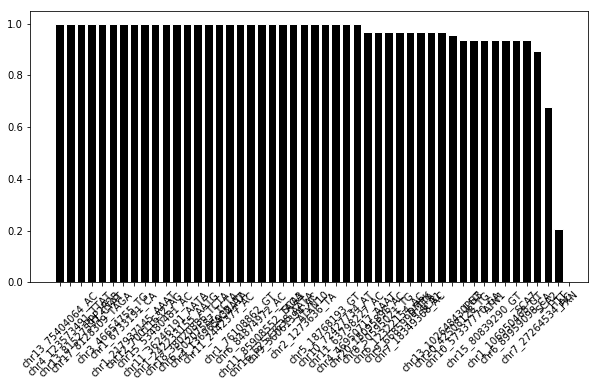

In [57]:
##### Per-locus accuracy
def GetDosage(x):
    if x == ".": return np.nan
    else: return sum([int(item) for item in x.split(",")])
    
calldata["dosage.hipstr"] = calldata["HipSTR"].apply(GetDosage)
calldata["dosage.gangstr"] = calldata["GangSTR"].apply(GetDosage)
calldata["dosage.cap"] = calldata["Cap.Binned"].apply(GetDosage)

loci = []
g_call = []
h_call = []
g_acc = []
h_acc = []

for locus in set(calldata["PrimerID"]):
    xx = calldata[calldata["PrimerID"]==locus]
    loci.append(locus)
    g_call.append(xx[~np.isnan(xx["dosage.gangstr"])].shape[0])
    h_call.append(xx[~np.isnan(xx["dosage.hipstr"])].shape[0])
    g_acc.append(np.mean(xx[~np.isnan(xx["dosage.gangstr"])]["match.gang"]))
    h_acc.append(np.mean(xx[~np.isnan(xx["dosage.hipstr"])]["match.hip"]))
    
locdata = pd.DataFrame({"PrimerID": loci, "g.call": g_call, "h.call": h_call, "g.acc": g_acc, "h.acc": h_acc})
locdata = locdata.sort_values(["h.acc"], ascending=False)

fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.bar(range(locdata.shape[0]), locdata["h.acc"], color="black", edgecolor="white")
ax.set_xticks(range(locdata.shape[0]))
ax.set_xticklabels(locdata["PrimerID"], rotation=45);

(-30, 30)

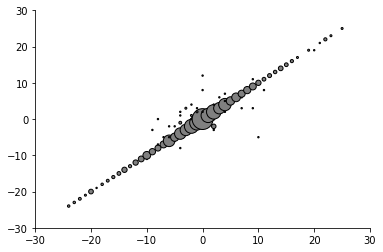

In [59]:
##### Bubble plot examples #####
#PrimerID="HTT"
#xx = calldata[(calldata["PrimerID"]==PrimerID) & (calldata["HipSTR"]!=".")].copy()
xx = calldata[(calldata["HipSTR"]!=".")].copy()

xxg = xx.groupby(["dosage.hipstr","dosage.cap"], as_index=False).agg({"SampleID": len})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xxg["dosage.cap"], xxg["dosage.hipstr"], s=xxg["SampleID"]*2, edgecolor="black", color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=-30, right=30)
ax.set_ylim(bottom=-30, top=30)

#xx[xx["dosage.hipstr"]!=xx["dosage.cap"]]

In [ ]:
############### Write matrix of product sizes ###########

psize_data = {} # PrimerID -> SampleID -> ProductSize
primer_ids = list(set(ref_prod_sizes["PrimerID"]))
primer_ids = [item for item in primer_ids if item not in rmloci]
samples = list(set(samp_prod_sizes["SampleID"]))

for pr in primer_ids:
    psize_data[pr] = {}
    psize_data[pr]["ref"] = ref_prod_sizes[ref_prod_sizes["PrimerID"]==pr]["ProductSize"].values[0]
    for sm in samples: psize_data[pr][sm] = "NA"
    
for i in range(samp_prod_sizes.shape[0]):
    pr = samp_prod_sizes["PrimerID"].values[i]
    if pr not in primer_ids: continue
    sm = samp_prod_sizes["SampleID"].values[i]
    prod = samp_prod_sizes["ProductSize"].values[i]
    psize_data[pr][sm] = prod

outf = open("../data/csv/psize_matrix.csv", "w")
outf.write(",".join(["PrimerID","RefProductSize"] + samples)+"\n")
for pr in primer_ids:
    items = [pr] + [psize_data[pr]["ref"]] + [psize_data[pr][sm] for sm in samples]
    outf.write(",".join([str(item) for item in items])+"\n")
outf.close()